# Metadata-based Specialization

One previously employed method for estimating the degree of specialization in parliament is the use of politician co-occurrence counts. By calculating the number of times two politicians speak in the same session, one can construct a "co-specialization" index, as Otjes and Louwerse show. In this notebook, I calculate co-specialization over time, based on co-occurrence counts. I use PMI to score the co-occurrences.

The PMI-scores are used to aggregate several signals:

- the mean co-specialization
- the variation in co-specialization
- the concentration of co-specialization (as measured in entropy)
- the modularity of co-specialization networks (as measured in modularity)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.stats import entropy
from tqdm import tqdm
from collections import Counter
from novelty.metrics import softmax
from novelty.afa import adaptive_filter
import networkx as nx
import math 
from itertools import combinations
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams['font.family'] = 'Aptos'

In [2]:
# Import Metadata
metadata = pd.read_csv('/home/rb/Documents/Data/metadata/metadata-full.tsv',sep='\t',parse_dates=['date'])
metadata = metadata[metadata.session_type == 'plenary']
metadata['py'] = metadata.speech_id.str.split('.').str[4].str[:8]
metadata['sess'] = metadata.speech_id.str.split('.').str[4:6].agg('.'.join)

names = dict(zip(metadata['member-ref'],metadata.speaker))
parties = dict(zip(metadata['member-ref'],metadata['party-ref']))

# Date Dictionaries
dates_topic = dict(zip(metadata.speech_id.str.split('.').str[4:6].str.join('.'), metadata.date))
dates_speech = dict(zip(metadata.speech_id, metadata.date))

# Change dates to 6-month bins, select only MPs, Plenaries, and remove joint House meetings

metadata['date'] = metadata.date.apply(lambda d: pd.Timestamp(year = d.year, month=1 if d.month < 7 else 6, day=1))
subset = metadata[(metadata.role == 'mp') & (metadata.py.str[4:6] == '19') & (metadata.date.dt.year > 1945)]

/tmp/ipykernel_399044/1992865185.py:5: FutureWarning: using <built-in method join of str object at 0x7549e4b9f1b0> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.
  metadata['sess'] = metadata.speech_id.str.split('.').str[4:6].agg('.'.join)


In [3]:
# Loop over periods and members. Calculate PMI between member-member pairs based on co-occurrence in session

r = []

for pyg in tqdm([[f"{i}{i+1}",f"{i+1}{i+2}"] for i in range(1945,1993)]):
    t = subset[subset.py.isin(pyg)]
    t = t[t['member-ref'].map(t['member-ref'].value_counts()) > 10]
    total_sessions = t.sess.nunique()

    for member1, session_dat1 in t.groupby('member-ref'):
        for member2, session_dat2 in t.groupby('member-ref'):
            if member1 != member2:
                f1 = session_dat1.sess.nunique()
                f2 = session_dat2.sess.nunique()
                f12 = len(set(session_dat1.sess.unique()).intersection(set(session_dat2.sess.unique())))
                if f12 > 5:
                    pmi = np.log2((f12 / total_sessions) / ((f1 / total_sessions) * (f2 / total_sessions)))
                    r.append({'member1':member1, 'member2':member2,'pmi': pmi,'py':pyg[0], 'totsess':total_sessions,'f12':f12, 'f1':f1, 'f2':f2})
                else:
                    r.append({'member1':member1, 'member2':member2,'pmi': -100,'py':pyg[1], 'totsess':total_sessions,'f12':f12, 'f1':f1, 'f2':f2})

100%|██████████| 48/48 [03:16<00:00,  4.10s/it]


In [5]:
rd = pd.DataFrame(r)

# Select only positive scores
rdn = rd[rd.pmi > -100]

/tmp/ipykernel_399044/2913229270.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rd[rd.py.str[:4].astype(int) > 1945].groupby('py').apply(lambda g: len(g[g.pmi > 0]) / len(g)).plot()


<Axes: xlabel='py'>

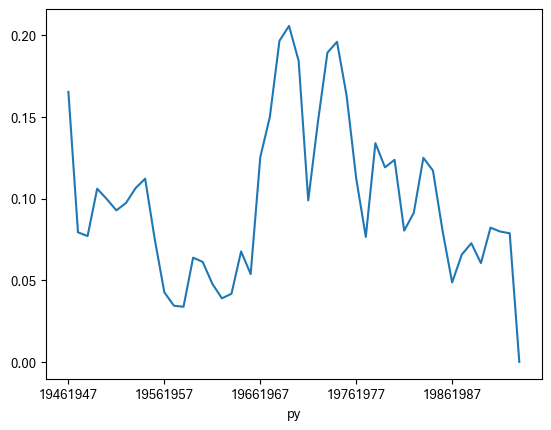

In [10]:
rd[rd.py.str[:4].astype(int) > 1945].groupby('py').apply(lambda g: len(g[g.pmi > 0]) / len(g)).plot()

In [11]:
# Based on the PMI-values, aggregate different signals

signals = pd.DataFrame({"py":sorted(rdn.py.unique())})

## Mean
signals = pd.merge(signals,rdn.groupby('py').pmi.mean().reset_index(name='mean_'), on='py')


## Variation
signals = pd.merge(signals,rdn.groupby('py').pmi.var().reset_index(name='variation'), on='py')

## Concentration
signals = pd.merge(signals,rdn.groupby('py').apply(lambda t:entropy(softmax(t.pmi))).reset_index(name='entropy'), on='py')

## Modularity
def get_mod(df):
    # df = df.groupby('member1').apply(lambda g: g.nlargest(10,'pmi'))
    G = nx.from_pandas_edgelist(df = df, source = 'member1', target = 'member2', edge_attr='pmi')
    comms = nx.community.louvain_communities(G,weight='pmi')
    return nx.community.quality.modularity(G,communities=comms)

# Smooth Signals, Remove Prewar debates
signals = pd.merge(signals,rdn[rdn.pmi > 0].groupby('py').apply(get_mod).reset_index(name='modularity'), on='py').set_index('py')
# signals = signals[signals.py.dt.year > 1945].apply(zscore)
# for c in signals.columns:
#     signals[c] = adaptive_filter(signals[c],span=10)

/tmp/ipykernel_399044/1751834235.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signals = pd.merge(signals,rdn.groupby('py').apply(lambda t:entropy(softmax(t.pmi))).reset_index(name='entropy'), on='py')
/tmp/ipykernel_399044/1751834235.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  signals = pd.merge(signals,rdn[rdn.pmi > 0].groupby('py').apply(get_mod).reset_index(name='modularity'), on='py').s

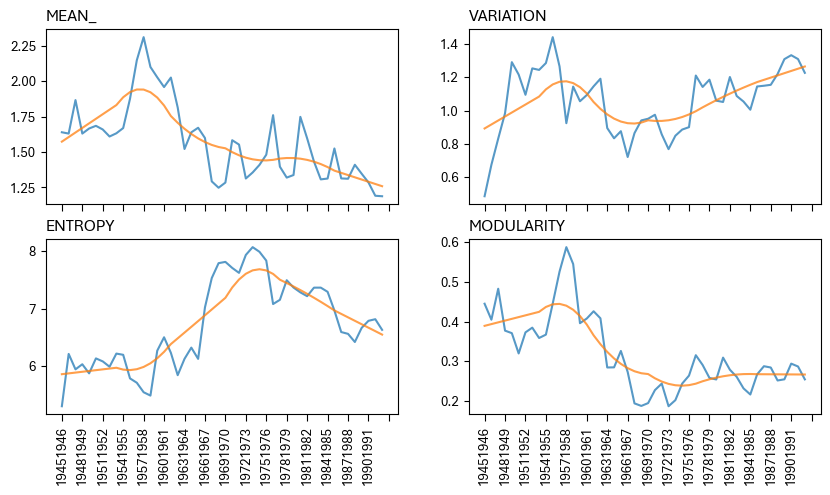

In [12]:
# Plot

f,a = plt.subplots(2,2,figsize=(10,5),sharex=True)

for cc,c in enumerate(signals):

    ax = a.flatten()[cc]
    ax.plot(signals.index,signals[c],alpha=.75)
    ax.plot(signals.index,adaptive_filter(signals[c],span=10),alpha=.75)
    ax.set_title(c.upper(),loc='left')
    ax.xaxis.set_tick_params(rotation=90,size=5)

    import matplotlib.ticker as plticker

    loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
# plt.savefig('figs/metadata-spec-stats.png',dpi=400)

In [ ]:
df = signals 

# Set up color palette for decades
decades = df.index.str[:4].astype(int) // 10 * 10  # Group years into decades
decade_palette = sns.color_palette("coolwarm", n_colors=len(set(decades)))

# Set up the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# # Plot scatter points colored by decades
# for i, (time, row) in enumerate(df.iterrows()):
#     decade_index = list(set(decades)).index(decades[i])
#     plt.scatter(row['entropy'], row['mean_'], color=decade_palette[decade_index])

# Calculate centroid positions for each decade
centroid_positions = {}
for decade in set(decades):
    points = df[df.index.str[:4].astype(int) // 10 * 10 == decade]
    centroid_positions[decade] = (np.mean(points['entropy']), np.mean(points['mean_']))

# Add annotation box for each decade
for decade, position in centroid_positions.items():
    color = decade_palette[list(set(decades)).index(decade)]
    plt.annotate(f"{decade}s", position, fontsize=10, ha='center', va='center',
                 bbox=dict(boxstyle="round", facecolor=color, edgecolor='black'),
                 color='black')

# Set labels and title
plt.xlabel('Entropy')
plt.ylabel('Variation')

# Show plot
# plt.savefig('figs/quadrant-entropy-variance.png',dpi=400)
plt.show()